# Russia-Ukraine Conflict Analysis

The following notebook works as a work of research for the analysis of data from the Ethereum network during the period of the Russian-Ukraine conflict.


## Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import seaborn as sns

In [2]:
sns.set_theme()

The first thing to do is import two classes to manage the analysis of degree for the Ethereum datasets in 2021 and compare it with the Russia invasion period (feb. 2022). First, we will use a class to manage the loading and preprocessing of the data.

Five datasets are required to use this class:

- Four "lookup" datasets. They contain 3-month historical data of the degree of all active accounts in each period. The first one has data from January to March, the second one has data from April to June and so forth.
- A single "lookup" dataset corresponding to the period of interest: The one with info from the beginning of the conflict, ranging from 2022 February 10th to 2022 March 10th.

These datasets need to be in the following format:

- They need to be in the same directory.
- They need to have the same name, differing only by a suffix (e.g. "lookup_1, lookup_2, lookup_3, lookup_4 and lookup_war"). These suffixes are hardcoded for now.

After giving information of the filenames and filepaths to that class, you can get a dataframe object back. With that object, we can use another class to use that dataframe object to make all the required analyses.

In [3]:
from data_processing import DegreeType, ETHDataProcessor
from degree_analysis import ETHDegreeAnalyzer

In [4]:
degree_collector = ETHDataProcessor(file_path = '../data/', degree_type = DegreeType.DEGREE)
in_degree_collector = ETHDataProcessor(file_path = '../data/', degree_type = DegreeType.IN_DEGREE)
out_degree_collector = ETHDataProcessor(file_path = '../data/', degree_type = DegreeType.OUT_DEGREE)

In [5]:
df = degree_collector.get_df()
degree_analyzer = ETHDegreeAnalyzer(df)
del df

In [6]:
df_in = in_degree_collector.get_df()

In [7]:
df_out = out_degree_collector.get_df()

In [8]:
asc_df = degree_analyzer.get_ascending_accounts(10, 1)
asc_df

,degree,avgValue1,avgValue2,avgValue3,avgValue4,totalVal,stdVal
0x58b6a8a3302369daec383334672404ee733ab239,100918.0,0.109653,0.163395,0.062899,0.170782,0.506730,0.050500
0x042523db4f3effc33d2742022b2490258494f8b3,33928.0,0.014993,0.025805,0.008046,0.015366,0.064210,0.007321
0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85,33602.0,0.063528,0.112568,0.224997,0.495149,0.896241,0.192952
0x60b86af869f23aeb552fb7f3cabd11b829f6ab2f,31479.0,0.015640,0.026144,0.007518,0.016731,0.066033,0.007626
0x352e504813b9e0b30f9ca70efc27a52d298f6697,14973.0,0.047664,0.073866,0.116231,0.277433,0.515194,0.103038
...,...,...,...,...,...,...,...
0xa902f4e54598e6a53c5ab4d1864e6e0d7e1daab0,2.0,0.166667,0.250000,0.166667,0.333333,0.916667,0.079786
0x3a780287c3a815c0f6238c43f816890f8dcb43f9,2.0,0.166667,0.250000,0.166667,0.333333,0.916667,0.079786
0xa8bdfad80221a5f346f051e1884e2033292d670a,2.0,0.166667,0.500000,0.166667,0.166667,1.000000,0.166667
0x3b191374225ece68c0cffd5ee78362c6ebfd4c41,2.0,0.333333,0.250000,0.166667,0.166667,0.916667,0.079786


In [9]:
dec_df = degree_analyzer.get_descending_accounts(10, 25)
dec_df

,degree,avgValue1,avgValue2,avgValue3,avgValue4,totalVal,stdVal
0x7a250d5630b4cf539739df2c5dacb4c659f2488d,323122.0,11.291720,11.785063,4.325878,3.749487,31.152147,4.341599
0xa1d8d972560c2f8144af871db508f0b0b10a3fbf,12394.0,22.384057,23.095934,9.519068,8.126217,63.125276,8.060523
0x340d693ed55d7ba167d184ea76ea2fd092a35bdc,4660.0,6.607725,7.948498,6.778755,4.989771,26.324750,1.216810
0xd07dc4262bcdbf85190c01c996b4c06a461d2430,4425.0,12.803315,7.462147,4.836309,0.914124,26.015895,4.987562
0xf6874c88757721a02f47592140905c4336dfbc61,3244.0,15.371147,19.653822,18.558364,4.555590,58.138923,6.896317
...,...,...,...,...,...,...,...
0x6ff7c2bb4cf130babd68851c2bce1020882bfc44,1.0,0.000000,5.000000,22.333333,4.333333,31.666667,9.863419
0x6ff509ceee56714519e15b55988a4a95eca43f43,1.0,12.000000,10.000000,2.333333,2.000000,26.333333,5.166667
0x6fee145963fccbc1adff7cd58dbd6bef7f0762d1,1.0,12.666667,10.500000,16.666667,2.666667,42.500000,5.888430
0x6fecdf9357f5d74bdb29f2b855222e34a40bcec0,1.0,22.000000,7.500000,9.333333,23.666667,62.500000,8.384703


In [19]:
def separate_degree_in_months(df: pd.DataFrame, hash: str) -> pd.DataFrame:
    long_asc = df.copy()
    long_asc['avgValue1'] = long_asc['avgValue1'] * long_asc['degree']
    long_asc['avgValue2'] = long_asc['avgValue2'] * long_asc['degree']
    long_asc['avgValue3'] = long_asc['avgValue3'] * long_asc['degree']
    long_asc['avgValue4'] = long_asc['avgValue4'] * long_asc['degree']
    long_asc.rename(inplace = True, 
                    columns = {'avgValue1': '02/21 to 04/21', 'avgValue2': '05/21 to 07/21',
                                'avgValue3': '08/21 to 10/21', 'avgValue4': '11/21 to 01/22',
                                'degree': 'Russian Invasion'}
    )
    long_asc = pd.melt(long_asc, ignore_index = False, value_vars= ['02/21 to 04/21', '05/21 to 07/21', 
                                                                    '08/21 to 10/21', '11/21 to 01/22', 'Russian Invasion'],
                       value_name='Degree', var_name = ['Time Period']
    )
    try: 
        result = long_asc.loc[hash].sort_values(by = ['Time Period'])
    except KeyError:
        return pd.DataFrame(index = [hash],
                            columns = {
                                'Degree': [0,0,0,0], 
                                'Time Period': ['02/21 to 04/21', '05/21 to 07/21', '08/21 to 10/21', '11/21 to 01/22', 'Russian Invasion']
                            }
        )
    return result        

def plot_account_grid(
        df: pd.DataFrame,
        hash_list: list,
        fig: plt.figure,
        lookup_in: pd.DataFrame,
        lookup_out: pd.DataFrame
    ) -> None:

    n = math.sqrt(len(hash_list))
    if not n.is_integer():
        raise ValueError('You need to use a square number of accounts.')
    n = int(n)
    outer = gridspec.GridSpec(n, n, wspace=0.6, hspace=0.6)
    for i in range(len(hash_list)):
        plt.xticks(rotation = 45)
        inner = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec = outer[i], wspace = 0.1, hspace = 0.4)
        ax = plt.Subplot(fig, inner[0])
        df_degree = separate_degree_in_months(df, hash_list[i])
        sns.lineplot(data = df_degree, x = 'Time Period', y = 'Degree', ax = ax)
        sns.scatterplot(data = df_degree, x = 'Time Period', y = 'Degree', ax = ax)
        ax.set_title(hash_list[i])
        fig.add_subplot(ax)

        ax_1 = plt.Subplot(fig, inner[1])
        df_in = separate_degree_in_months(lookup_in, hash_list[i])
        sns.lineplot(data = df_in, x = 'Time Period', y = 'Degree', ax = ax_1)
        sns.scatterplot(data = df_in, x = 'Time Period', y = 'Degree', ax = ax_1)
        fig.add_subplot(ax_1)

        ax_2 = plt.Subplot(fig, inner[2])
        df_out = separate_degree_in_months(lookup_out, hash_list[i])
        sns.lineplot(data = df_out, x = 'Time Period', y = 'Degree', ax = ax_2)
        sns.scatterplot(data = df_out, x = 'Time Period', y = 'Degree', ax = ax_2)
        fig.add_subplot(ax_2)

## Análises Provisório

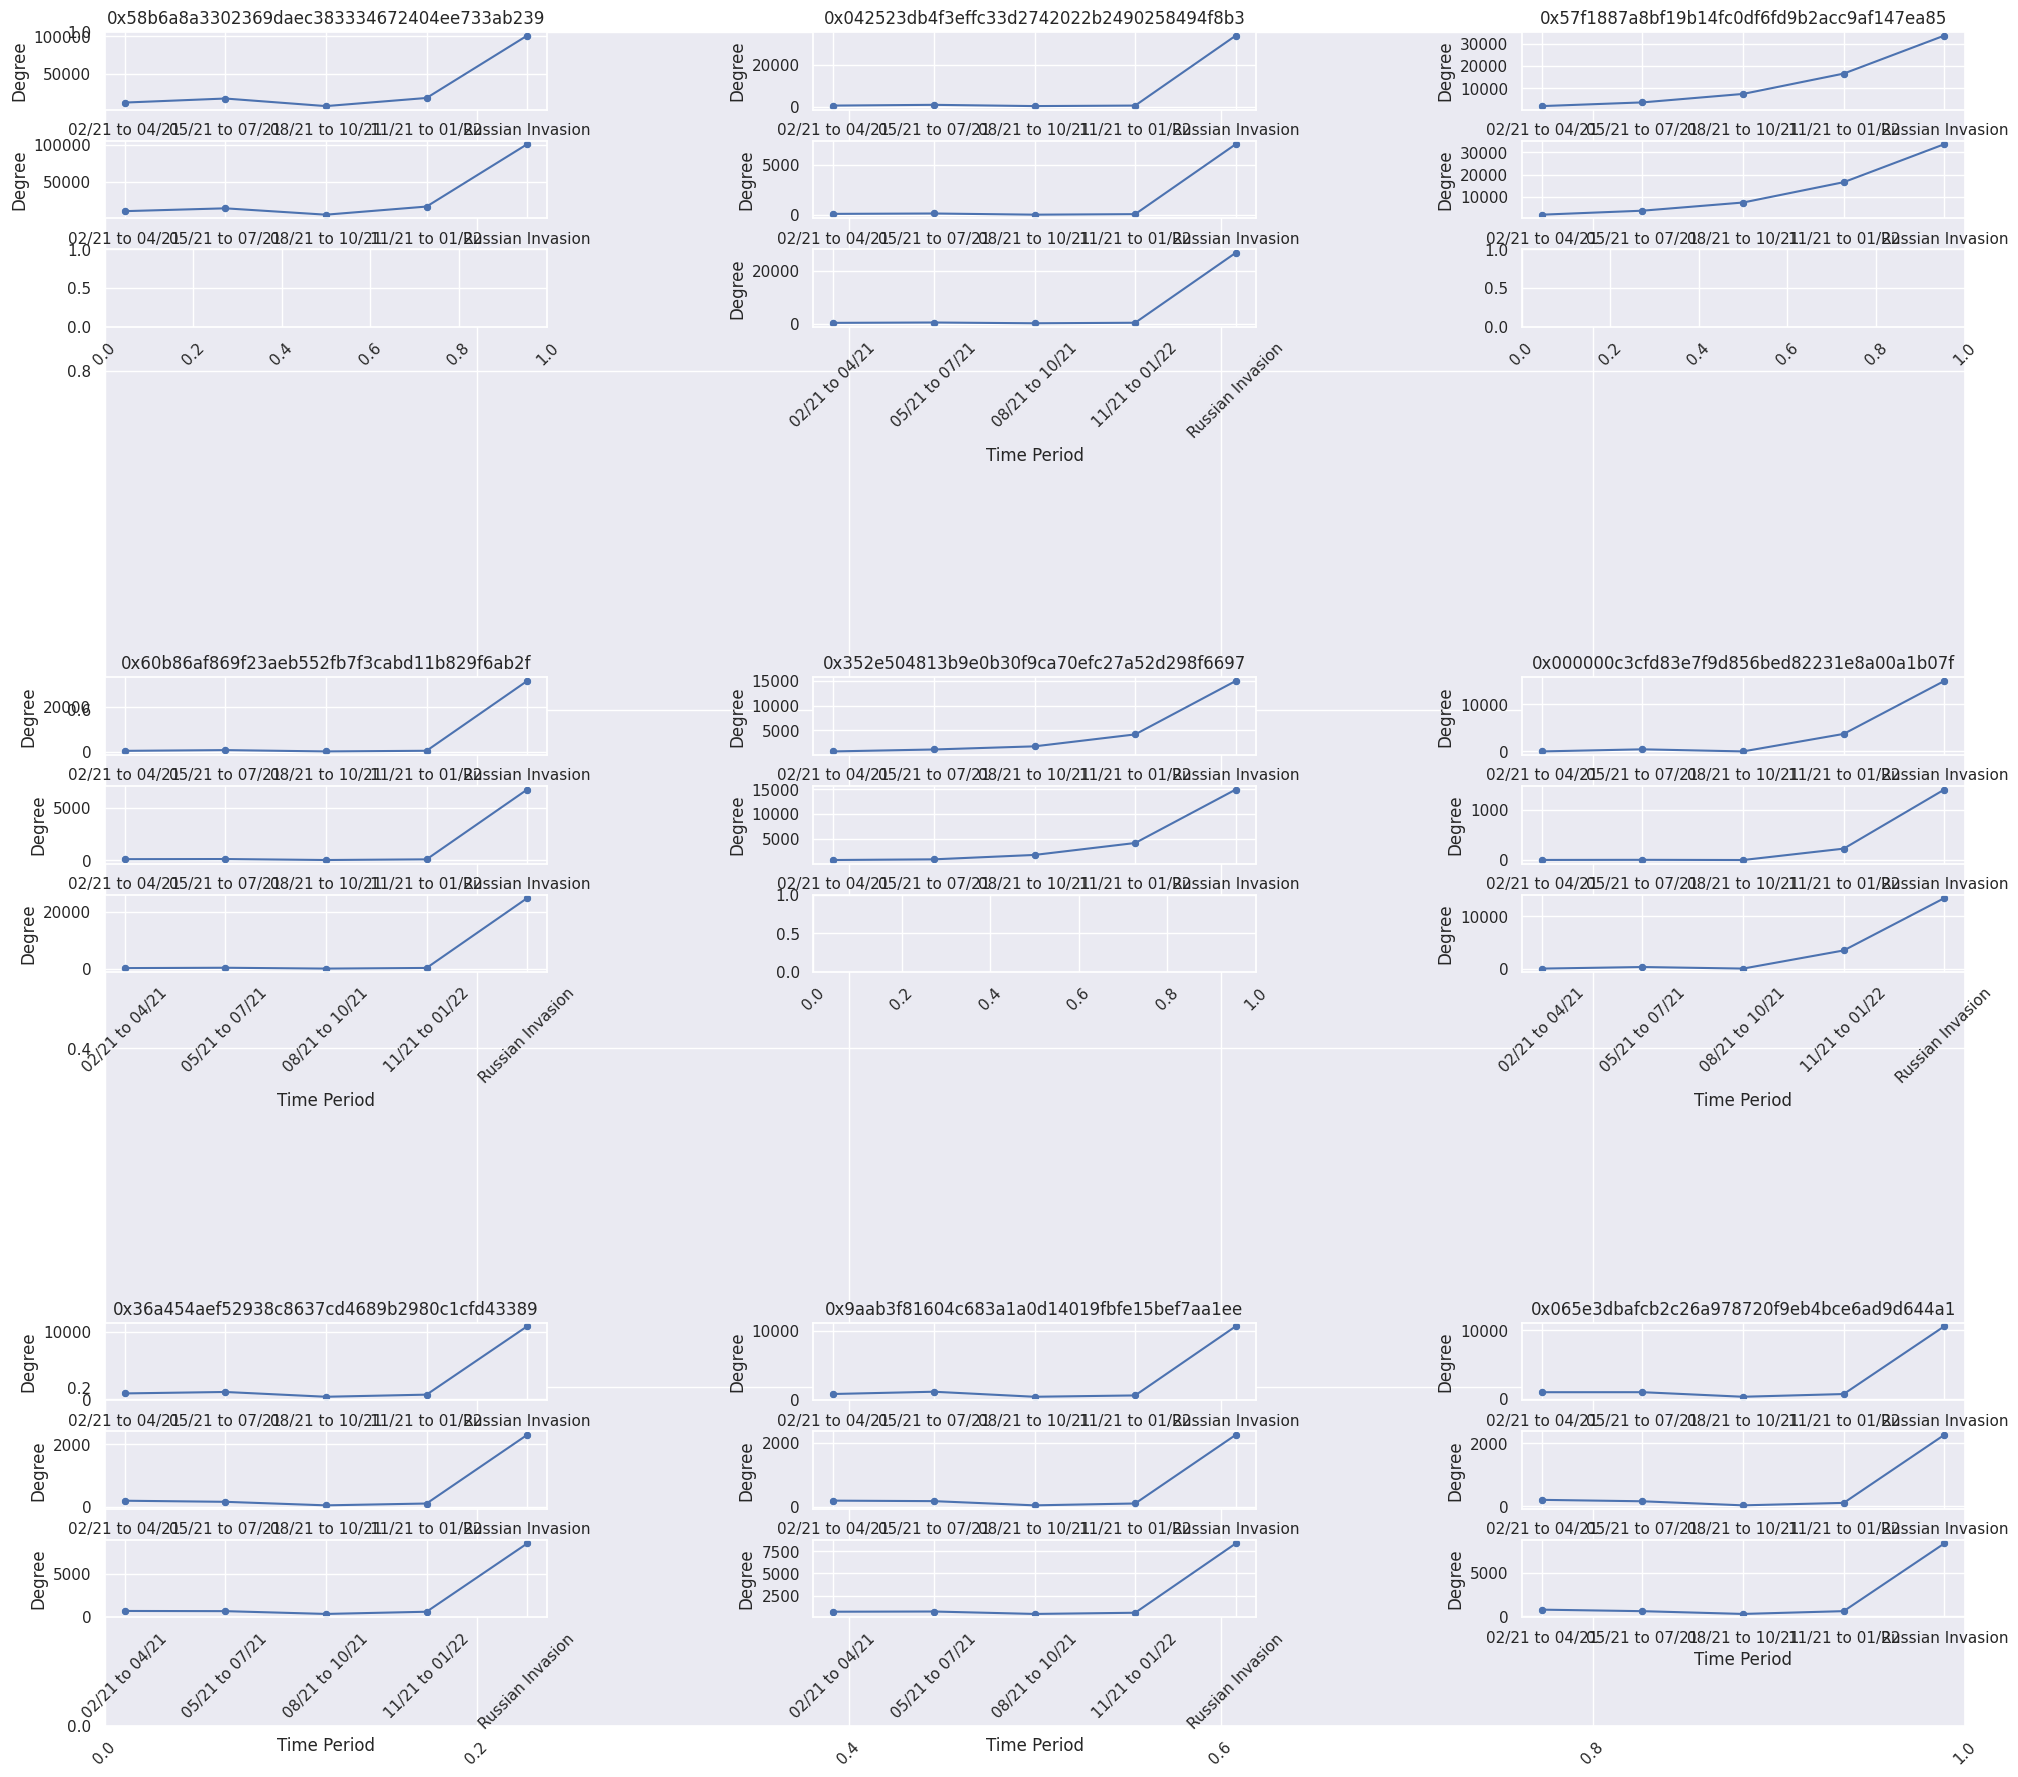

In [20]:
fig = plt.figure(figsize=(24, 22))
top_ascending_hashes = list(asc_df.iloc[:9].index)
plot_account_grid(asc_df, top_ascending_hashes, fig, df_in, df_out)

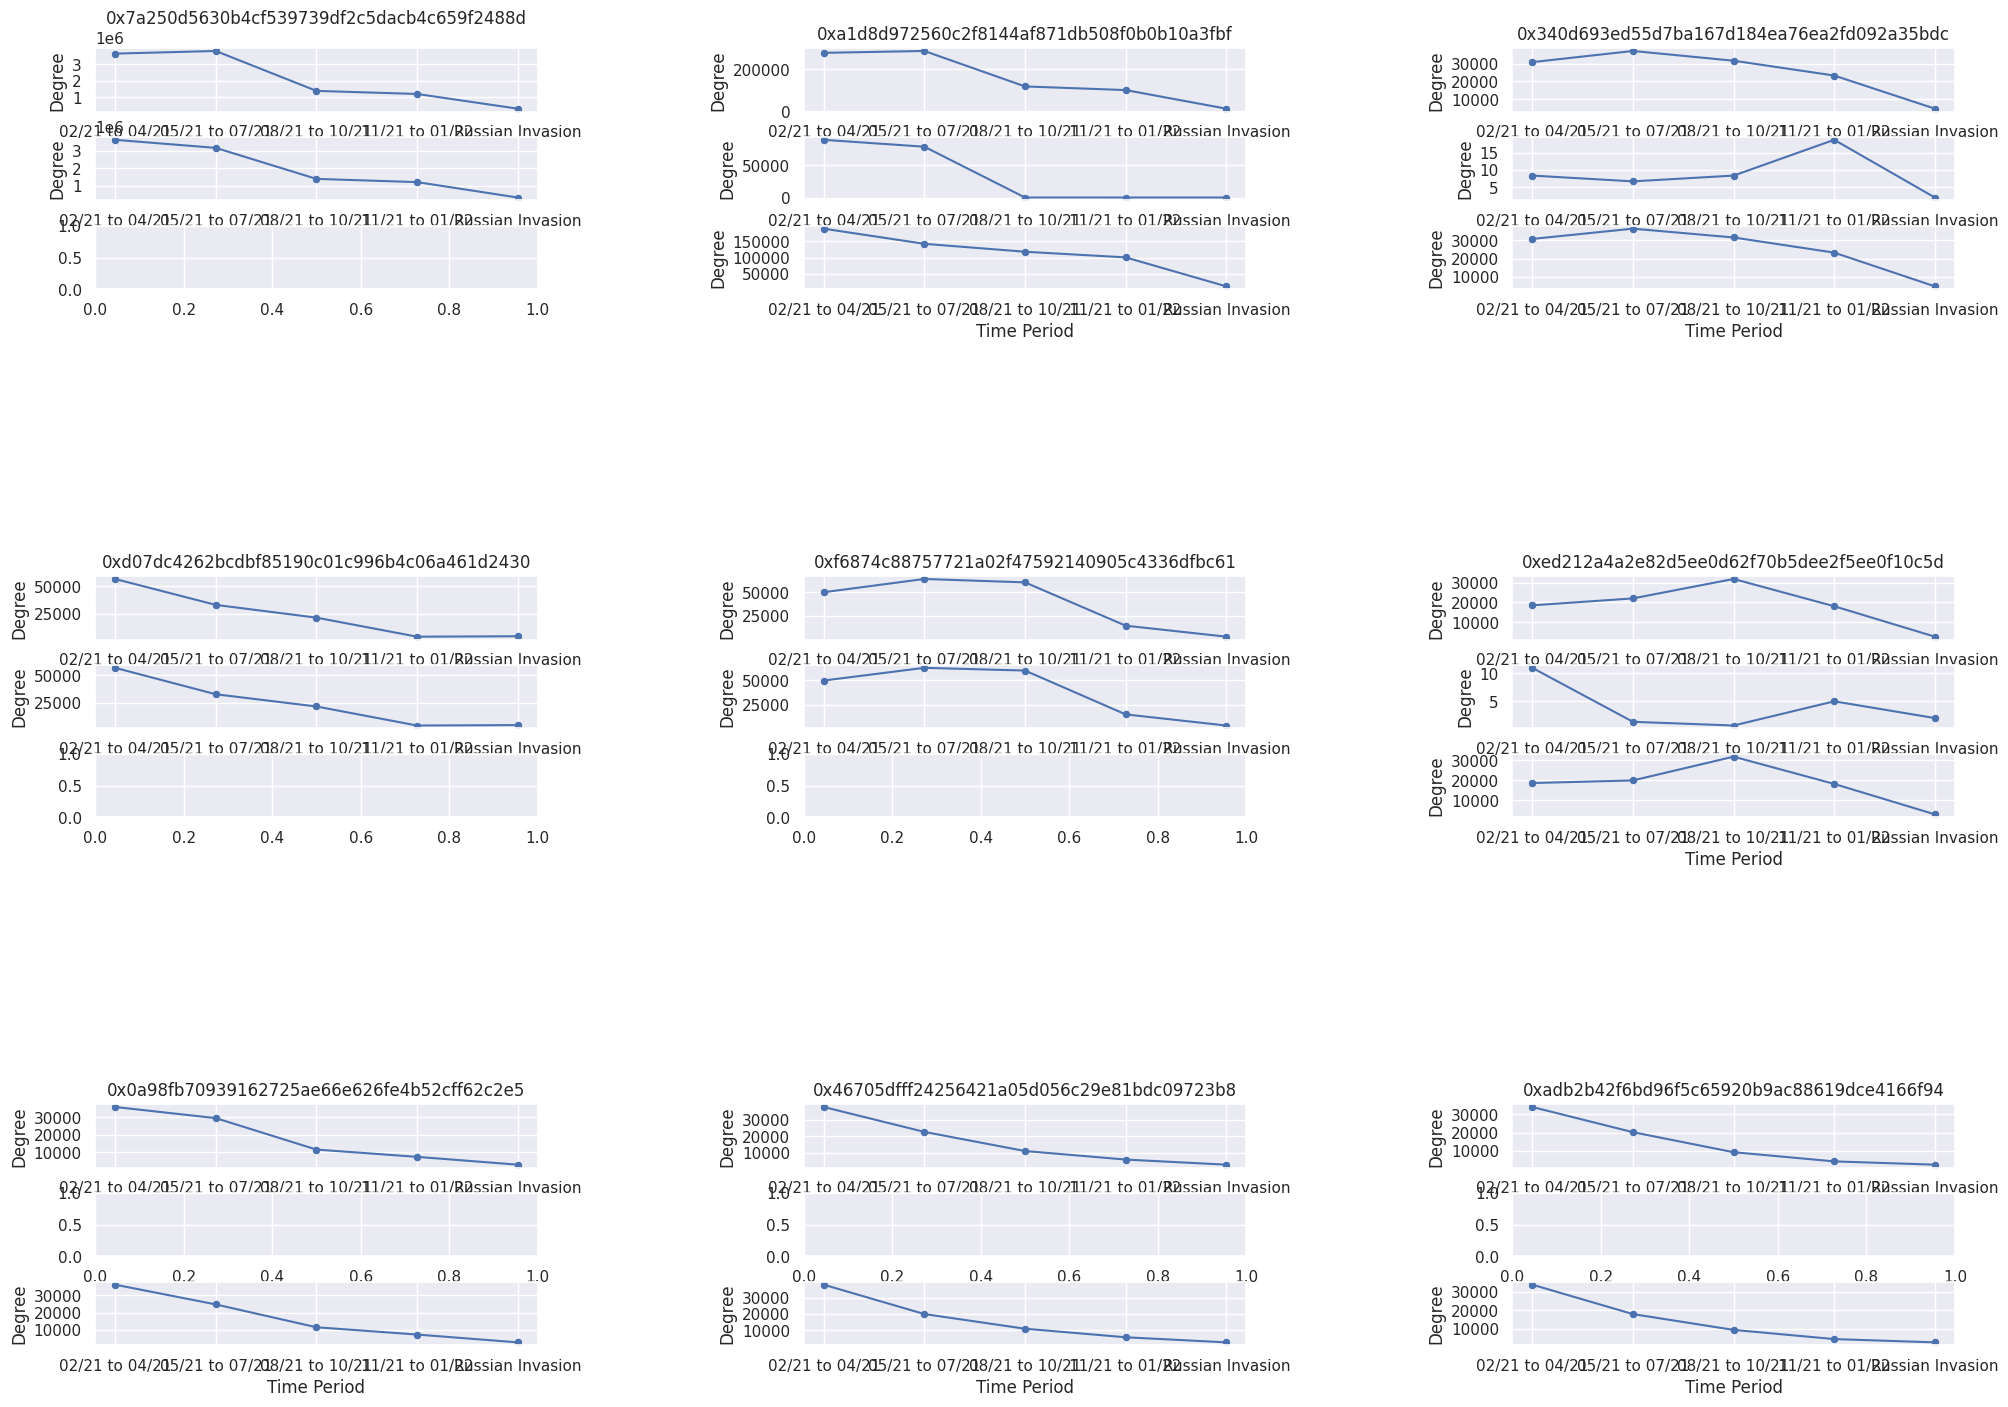

In [14]:
fig = plt.figure(figsize=(24, 18))
top_descending_hashes = list(dec_df.iloc[:9].index)
plot_account_grid(dec_df, top_descending_hashes, fig, df_in, df_out)

### In-Degree

In [25]:
asc_df = degree_analyzer.get_ascending_accounts(10, 1)
asc_df

,degree,avgValue1,avgValue2,avgValue3,totalVal,stdVal
to,,,,,,
0xfbddadd80fe7bda00b901fbaf73803f2238ae655,248829,0.078596,0.158030,0.297560,0.534186,0.110848
0x283af0b28c62c092c9727f1ee09c02ca627eb7f5,152168,0.136691,0.304979,0.515829,0.957499,0.189967
0x15d4c048f83bd7e37d49ea4c83a07267ec4203da,111325,0.097795,0.099966,0.268233,0.465993,0.097782
0x58b6a8a3302369daec383334672404ee733ab239,100918,0.109653,0.147341,0.062899,0.319893,0.042302
0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,100760,0.000010,0.230793,0.240333,0.471136,0.136080
...,...,...,...,...,...,...
0xb99d01cb75e3291edb4571a76b11079ad1127c4e,2,0.166667,0.166667,0.333333,0.666667,0.096225
0xb99c46ccd1b0fc286e5b270cfa08175735842f2c,2,0.333333,0.333333,0.166667,0.833333,0.096225
0xb9bbe7477a1991fc9a467d0a21fb84869b36e256,2,0.166667,0.333333,0.166667,0.666667,0.096225


In [27]:
dec_df = degree_analyzer.get_descending_accounts(10, 25)
dec_df

,degree,avgValue1,avgValue2,avgValue3,totalVal,stdVal
to,,,,,,
0x7a250d5630b4cf539739df2c5dacb4c659f2488d,323122,11.291720,9.854051,4.325878,25.471648,3.677647
0xf6874c88757721a02f47592140905c4336dfbc61,3244,15.371147,19.431771,18.558364,53.361282,2.137361
0x60f80121c31a0d46b5279700f9df786054aa5ee5,2261,22.979360,10.060445,6.624797,39.664603,8.623357
0xdd974d5c2e2928dea5f71b9825b8b646686bd200,1895,15.885136,7.353386,2.027617,25.266139,6.990296
0xab8e74017a8cc7c15ffccd726603790d26d7deca,1635,14.401427,11.341081,3.447299,29.189806,5.651997
...,...,...,...,...,...,...
0xf506835937f5fab0ffff1782c99c376111b31203,1,17.000000,15.000000,27.000000,59.000000,6.429101
0xf50f29a8357a4ce5e4cf461cddf7a0198f0cf44e,1,20.333333,7.666667,1.333333,29.333333,9.674326
0xf4f9d993b044754e8086df1948eb40ce5d59fcdf,1,13.666667,18.666667,1.666667,34.000000,8.736895


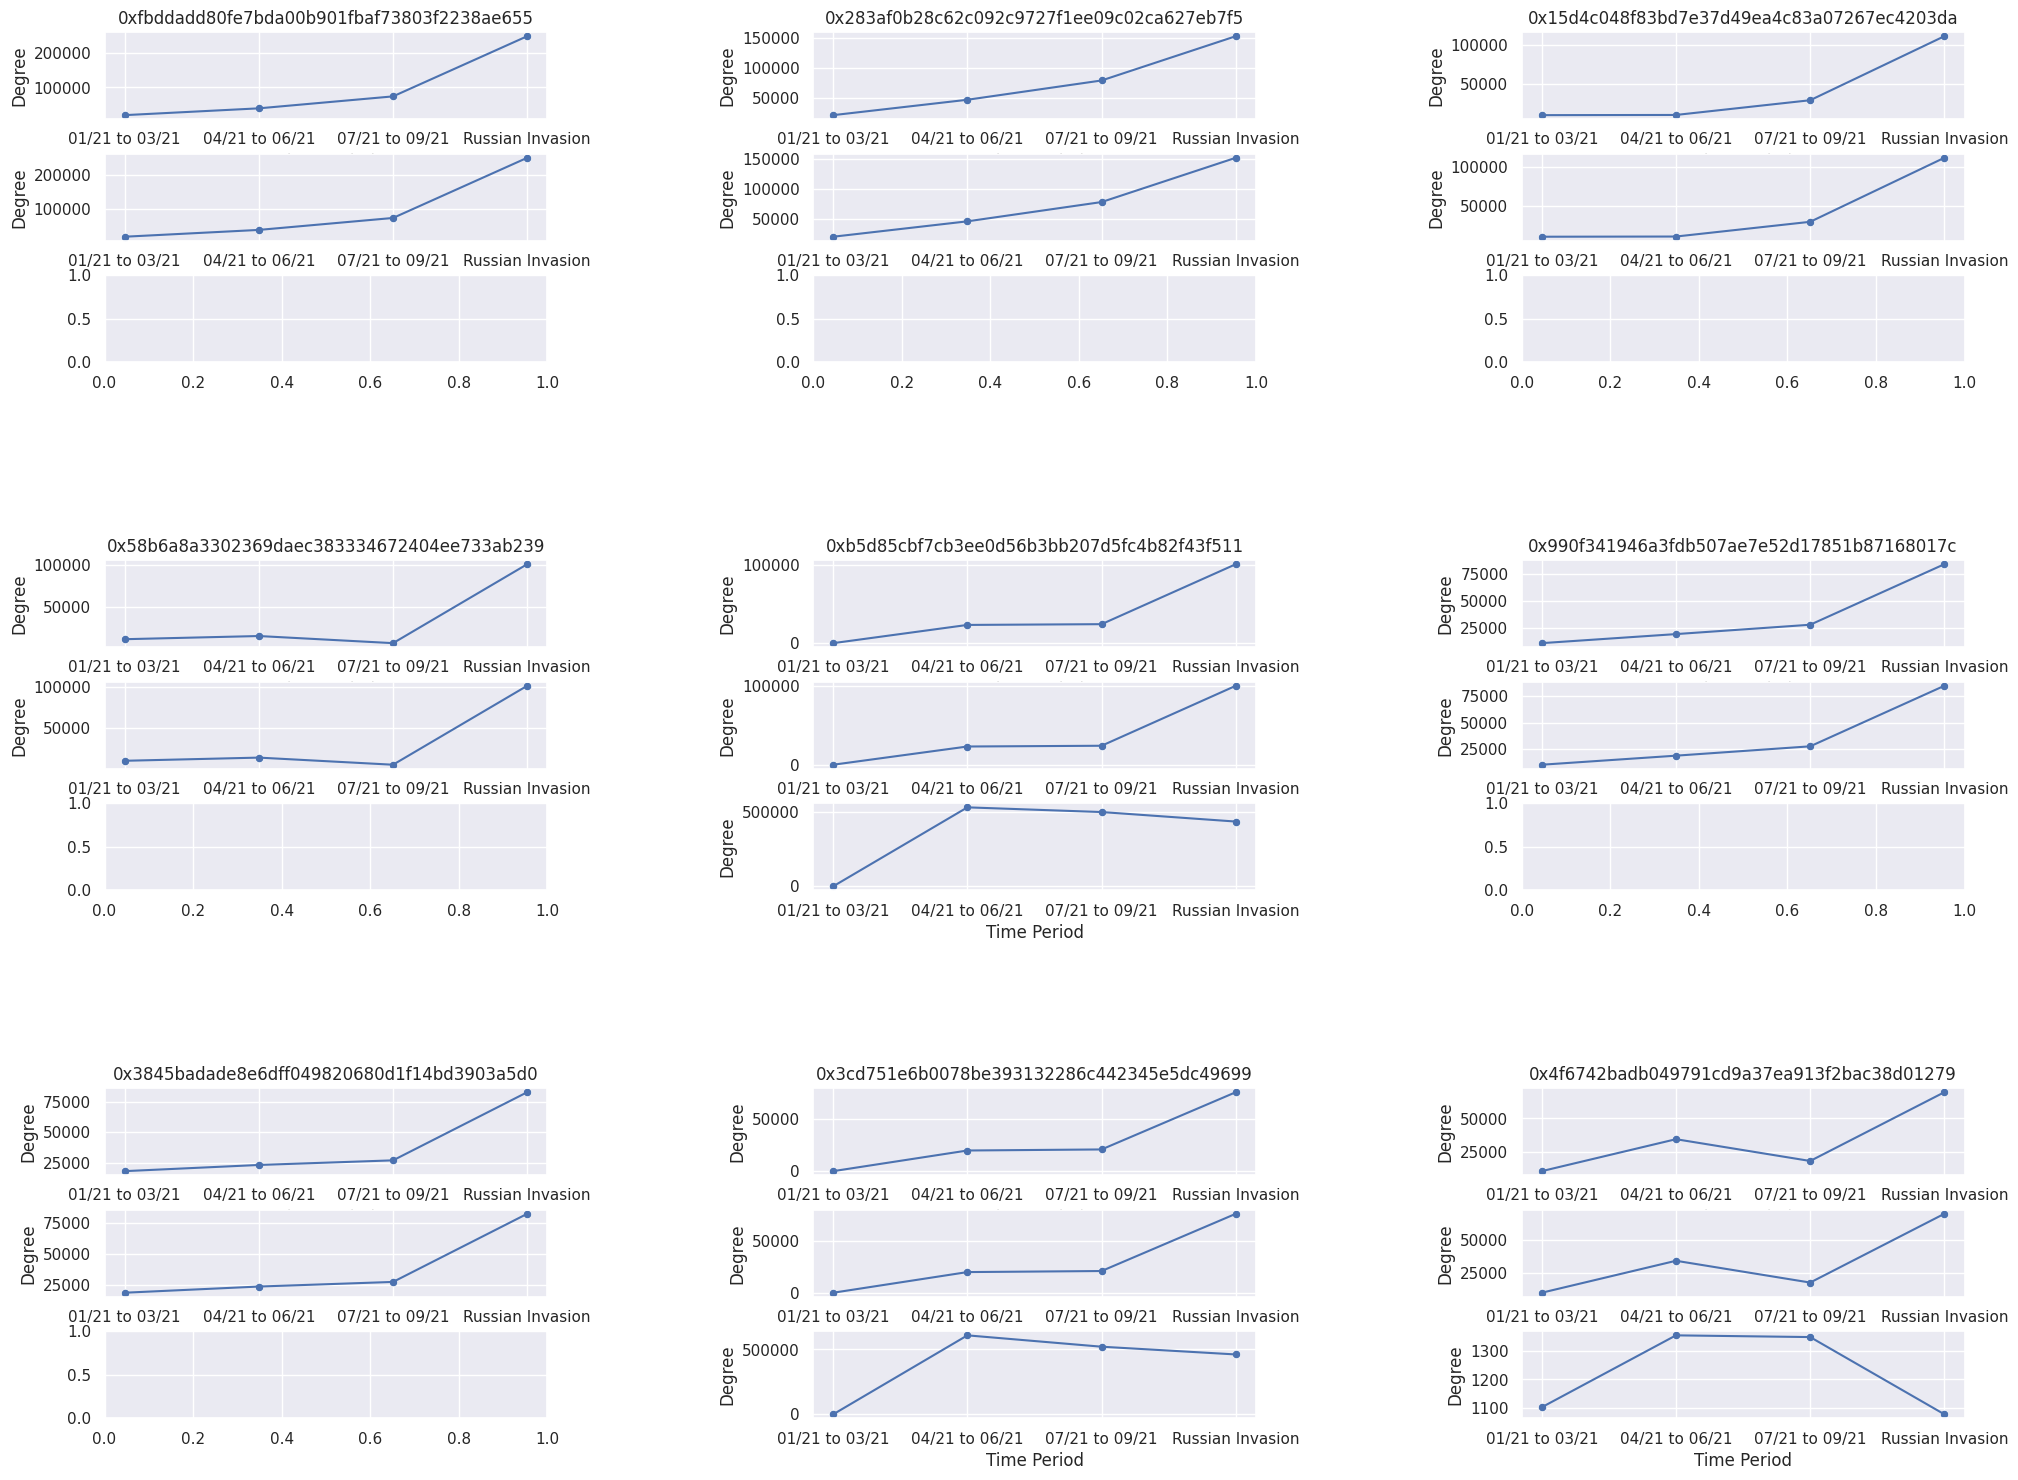

In [28]:
fig = plt.figure(figsize=(24, 18))
top_ascending_hashes = list(asc_df.iloc[:9].index)
plot_account_grid(asc_df, top_ascending_hashes, fig, df_in, df_out)

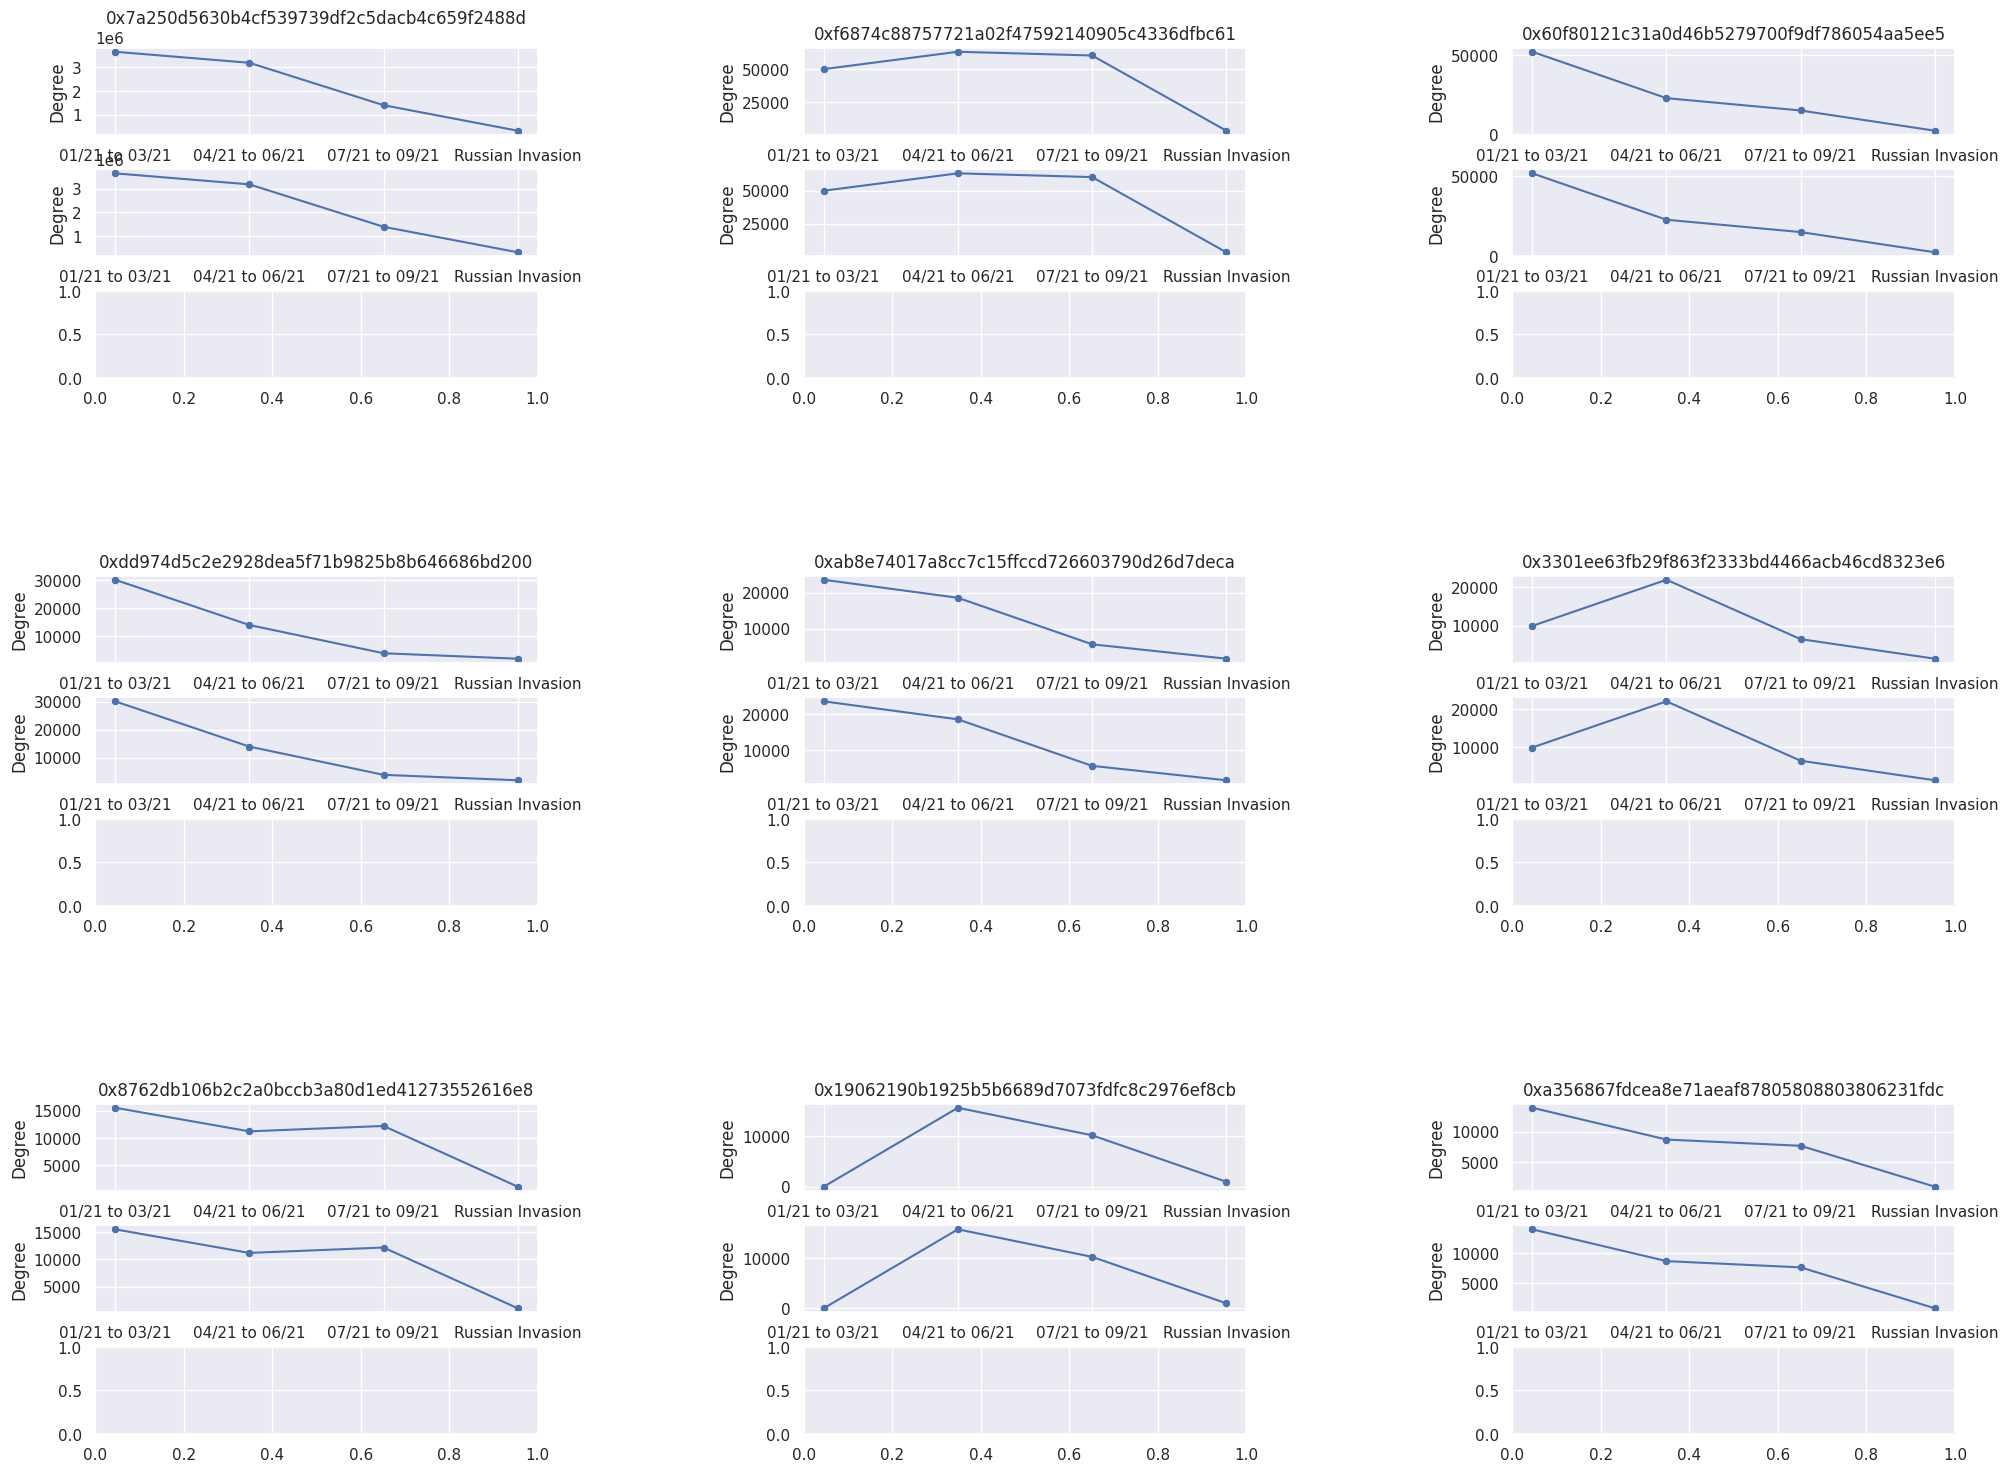

In [30]:
fig = plt.figure(figsize=(24, 18))
top_descending_hashes = list(dec_df.iloc[:9].index)
plot_account_grid(dec_df, top_descending_hashes, fig, df_in, df_out)

### Out-Degree

In [32]:
degree_analyzer = ETHDegreeAnalyzer(df_out)
asc_df = degree_analyzer.get_ascending_accounts(10, 1)
dec_df = degree_analyzer.get_descending_accounts(10, 25)

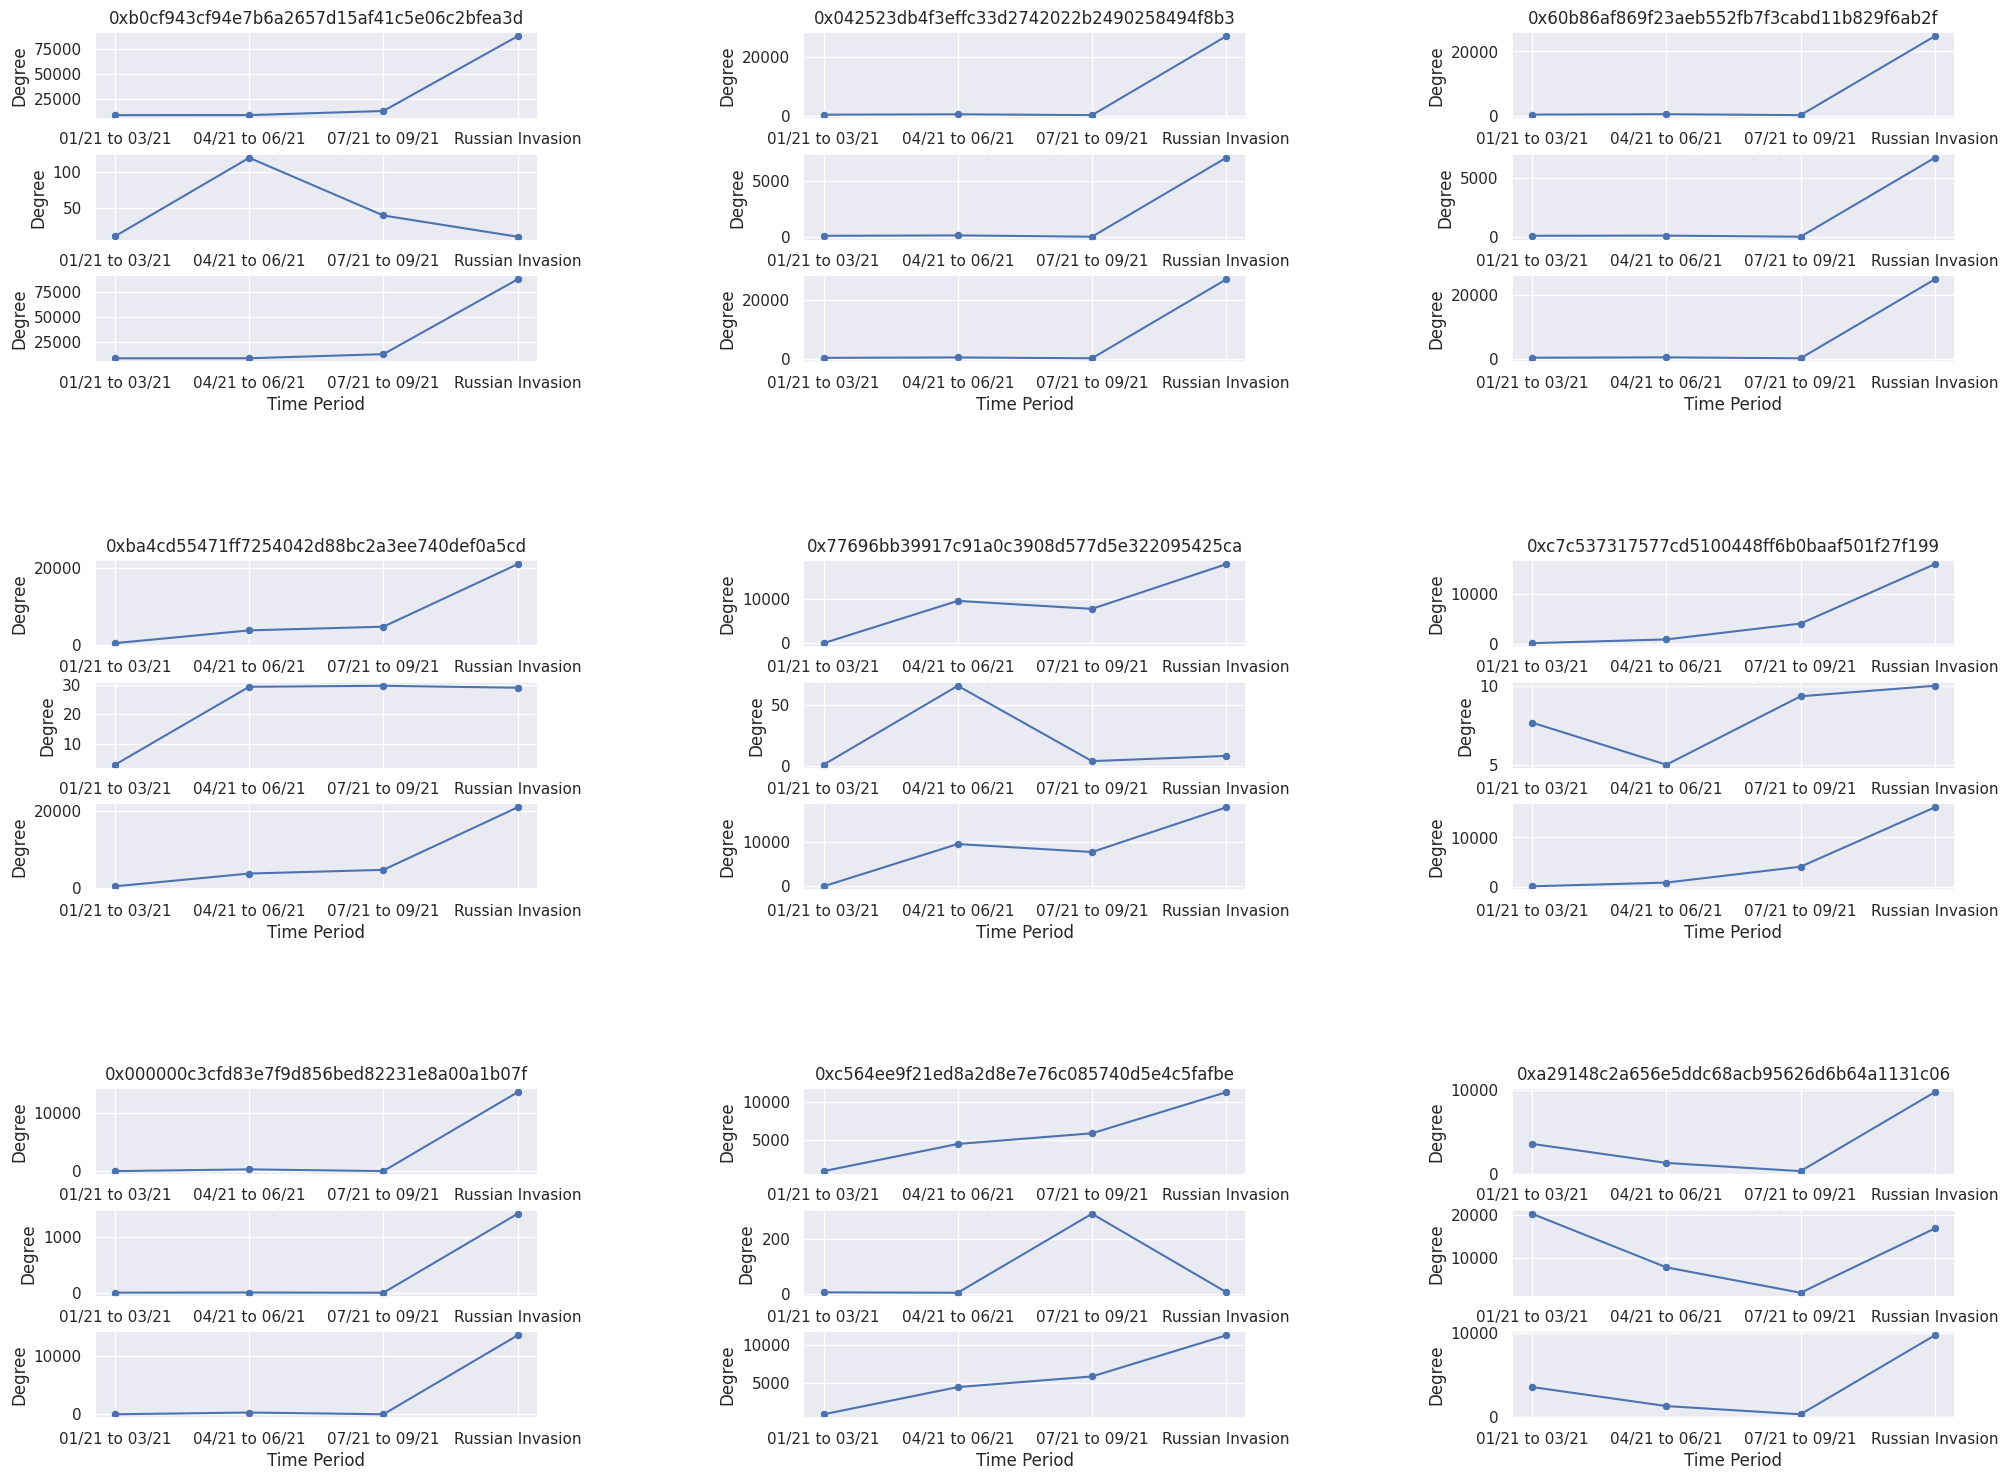

In [33]:
fig = plt.figure(figsize=(24, 18))
top_ascending_hashes = list(asc_df.iloc[:9].index)
plot_account_grid(asc_df, top_ascending_hashes, fig, df_in, df_out)

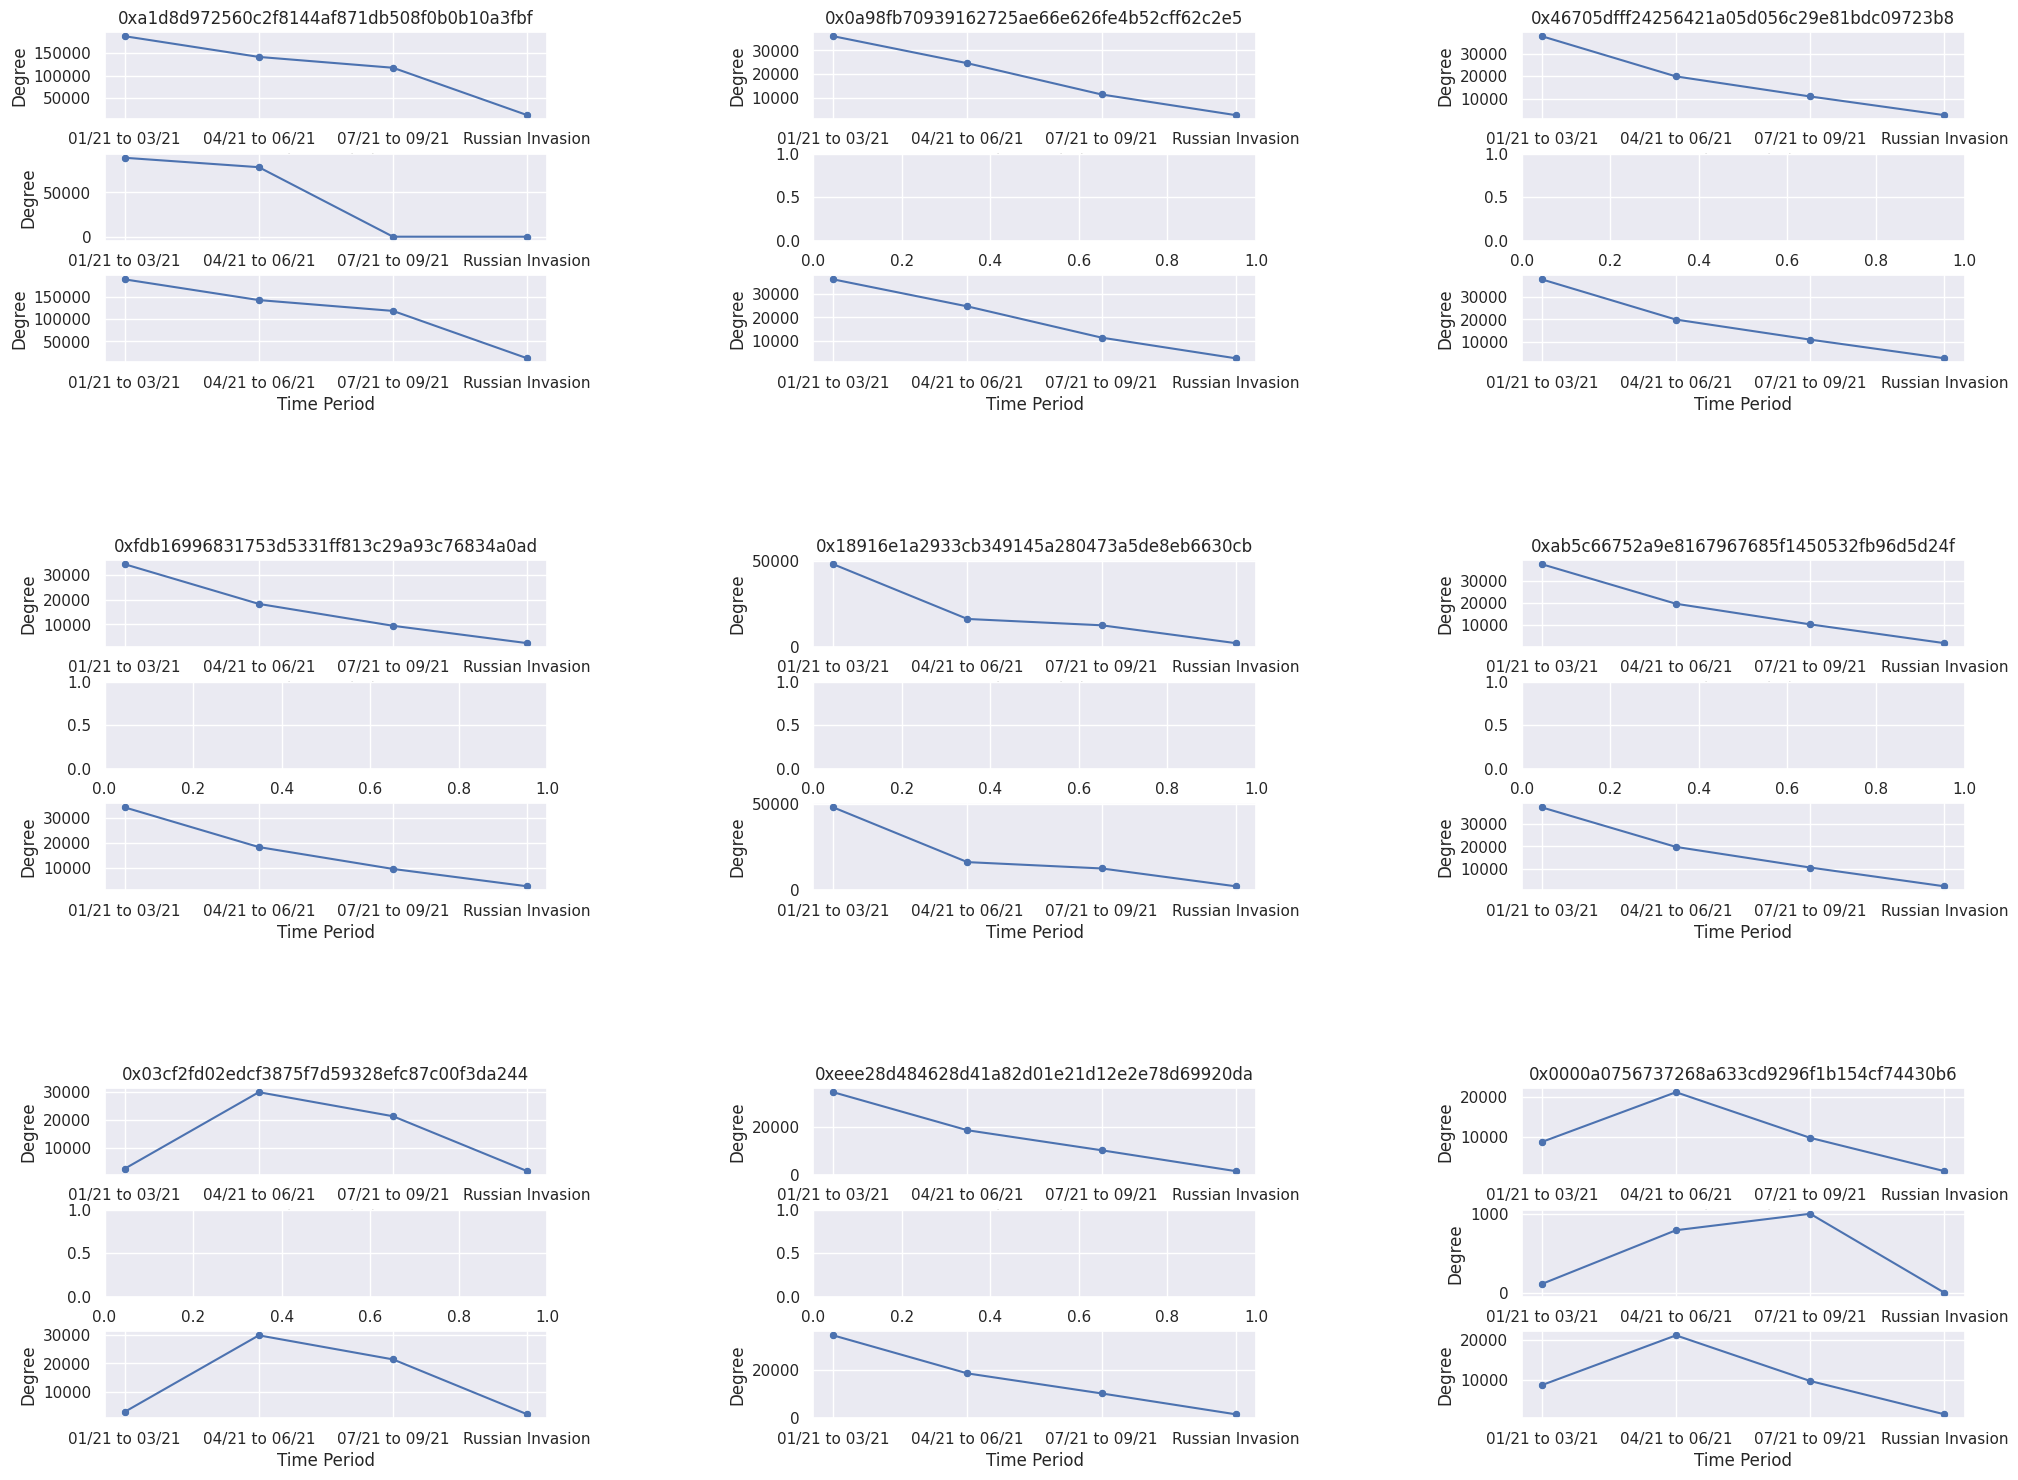

In [34]:
fig = plt.figure(figsize=(24, 18))
top_descending_hashes = list(dec_df.iloc[:9].index)
plot_account_grid(dec_df, top_descending_hashes, fig, df_in, df_out)

In [5]:
def plot_ascending_account(
        df: pd.DataFrame,
        hash: str,
        ax: plt.Axes,
        lookup_in: pd.DataFrame = None,
        lookup_out: pd.DataFrame = None,
    ) -> None:
    sns.set_theme()
    long_asc = df.copy()
    long_asc['avgValue1'] = long_asc['avgValue1']*long_asc['degree']
    long_asc['avgValue2'] = long_asc['avgValue2']*long_asc['degree']
    long_asc['avgValue3'] = long_asc['avgValue3']*long_asc['degree']
    long_asc.rename(inplace = True, 
                    columns = {'avgValue1': '01/21 to 03/21', 'avgValue2': '04/21 to 06/21',
                                'avgValue3': '07/21 to 09/21', 'degree': 'Russian Invasion'}
    )
    long_asc = pd.melt(long_asc, ignore_index = False, value_vars= ['01/21 to 03/21', '04/21 to 06/21', 
                                                                    '07/21 to 09/21', 'Russian Invasion'],
                       value_name='Degree', var_name = ['Time Period']
    )
    sns.lineplot(data = long_asc.loc[hash].sort_values(by = ['Time Period']), x = 'Time Period', y = 'Degree', ax = ax)
    sns.scatterplot(data = long_asc.loc[hash].sort_values(by = ['Time Period']), x = 'Time Period', y = 'Degree', ax = ax)

    if lookup_in is not None:
        lookup_in['avgValue1'] = lookup_in['avgValue1']*lookup_in['degree']
        lookup_in['avgValue2'] = lookup_in['avgValue2']*lookup_in['degree']
        lookup_in['avgValue3'] = lookup_in['avgValue3']*lookup_in['degree']
        lookup_in.rename(inplace = True, 
                        columns = {'avgValue1': '01/21 to 03/21', 'avgValue2': '04/21 to 06/21',
                                    'avgValue3': '07/21 to 09/21', 'degree': 'Russian Invasion'}
        )
        lookup_in = pd.melt(lookup_in, ignore_index = False, value_vars= ['01/21 to 03/21', '04/21 to 06/21', 
                                                                        '07/21 to 09/21', 'Russian Invasion'],
                        value_name='Degree', var_name = ['Time Period']
        )

        sns.lineplot(data = lookup_in.loc[hash].sort_values(by = ['Time Period']), x = 'Time Period', y = 'Degree', ax = ax.twinx())
        sns.scatterplot(data = lookup_in.loc[hash].sort_values(by = ['Time Period']), x = 'Time Period', y = 'Degree', ax = ax.twinx())
    ax.set_title(hash)

In [8]:
del degree_analyzer
degree_analyzer = ETHDegreeAnalyzer(lookup_path='../data/', degree_type=DegreeType.OUT_DEGREE)
lookup_out = degree_analyzer.get_ascending_accounts(10, 1)

                                                 Time Period       Degree
from                                                                     
0xb0cf943cf94e7b6a2657d15af41c5e06c2bfea3d    01/21 to 03/21  8902.333333
0x042523db4f3effc33d2742022b2490258494f8b3    01/21 to 03/21   399.666667
0x60b86af869f23aeb552fb7f3cabd11b829f6ab2f    01/21 to 03/21   382.000000
0xba4cd55471ff7254042d88bc2a3ee740def0a5cd    01/21 to 03/21   505.333333
0x77696bb39917c91a0c3908d577d5e322095425ca    01/21 to 03/21    14.666667
...                                                      ...          ...
0x71bee6e57fbb9f7213cdb0fea07a082f77519c09  Russian Invasion     2.000000
0x7f66b27da2ddcdc1b4c4a2aaf608d7ecb68588d7  Russian Invasion     2.000000
0x71b212e65acf711017368e0c86c8a39bbf47b404  Russian Invasion     2.000000
0x7f65bfef5d242a53243462d5034e6e0cfa1fde65  Russian Invasion     2.000000
0xdf598aa801a19f9f15b5491ee64c80aa5f5bbae2  Russian Invasion     2.000000

[143656 rows x 2 columns]
           

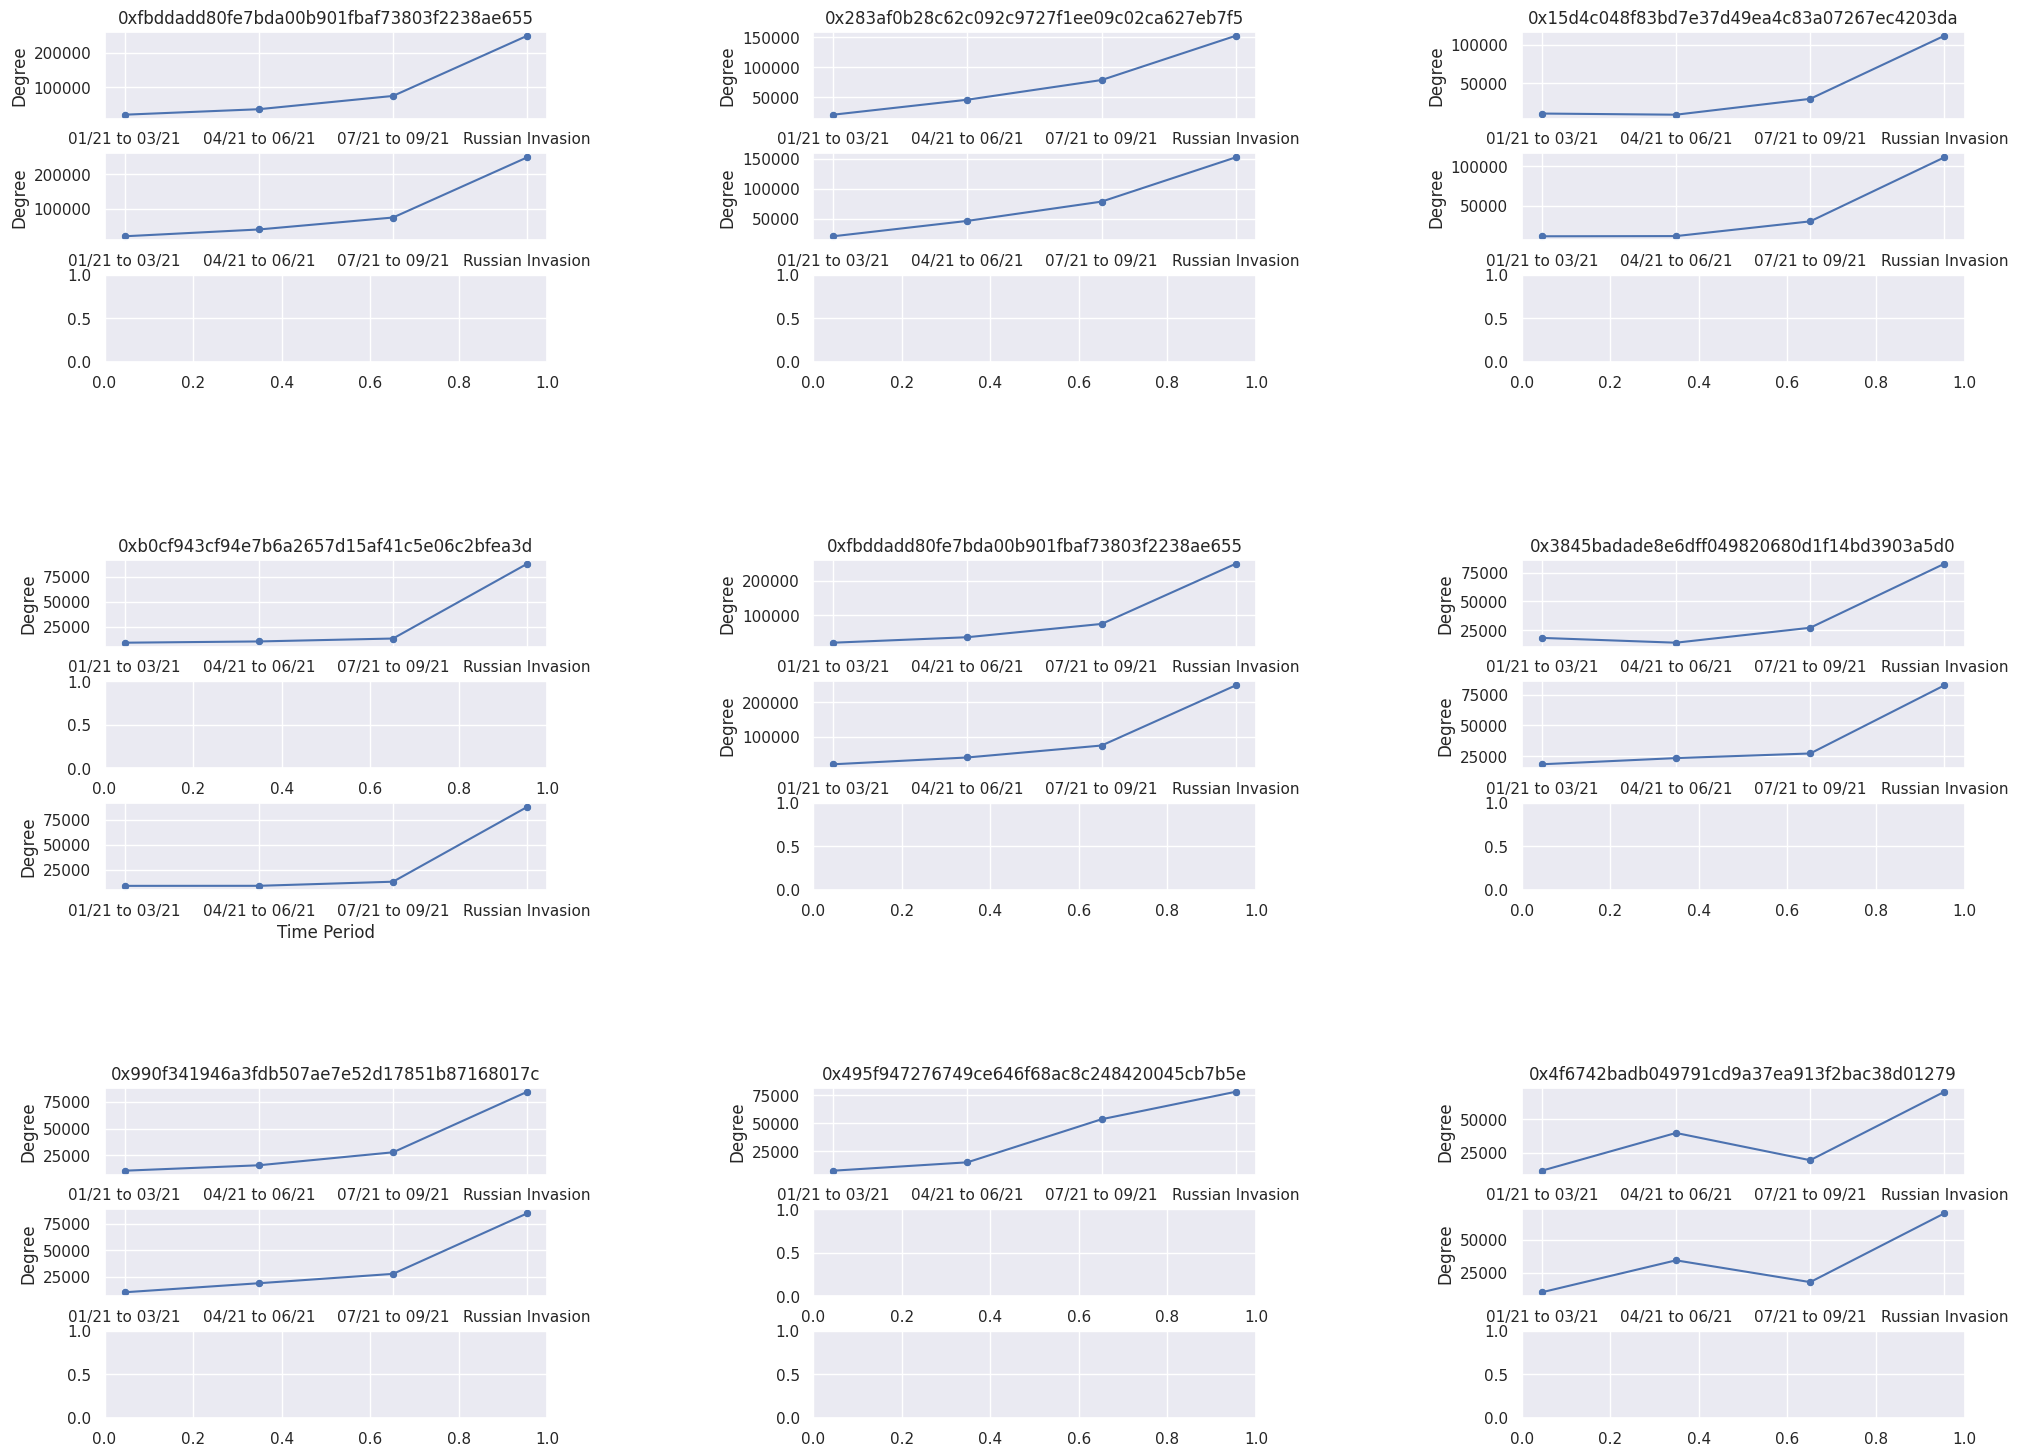

In [16]:
fig = plt.figure(figsize=(24, 18))
#fig, axes = plt.subplots(3, 3, figsize=(24, 18))
hash_list = [
    '0xfbddadd80fe7bda00b901fbaf73803f2238ae655',
    '0x283af0b28c62c092c9727f1ee09c02ca627eb7f5',
    '0x15d4c048f83bd7e37d49ea4c83a07267ec4203da',
    '0xb0cf943cf94e7b6a2657d15af41c5e06c2bfea3d',
    '0xfbddadd80fe7bda00b901fbaf73803f2238ae655',
    '0x3845badade8e6dff049820680d1f14bd3903a5d0',
    '0x990f341946a3fdb507ae7e52d17851b87168017c',
    '0x495f947276749ce646f68ac8c248420045cb7b5e',
    '0x4f6742badb049791cd9a37ea913f2bac38d01279'
             ]
plot_ascending_accounts(asc_df, hash_list, fig, lookup_in, lookup_out)
#plot_ascending_account(asc_df, '0xfbddadd80fe7bda00b901fbaf73803f2238ae655', fig)
#plot_ascending_account(asc_df, '0x283af0b28c62c092c9727f1ee09c02ca627eb7f5', fig)
#plot_ascending_account(asc_df, '0x15d4c048f83bd7e37d49ea4c83a07267ec4203da', fig)
#plot_ascending_account(asc_df, '0x58b6a8a3302369daec383334672404ee733ab239', fig)
#plot_ascending_account(asc_df, '0xb0cf943cf94e7b6a2657d15af41c5e06c2bfea3d', fig)
#plot_ascending_account(asc_df, '0x990f341946a3fdb507ae7e52d17851b87168017c', fig)
#plot_ascending_account(asc_df, '0x3845badade8e6dff049820680d1f14bd3903a5d0', fig)
#plot_ascending_account(asc_df, '0x495f947276749ce646f68ac8c248420045cb7b5e', fig)
#plot_ascending_account(asc_df, '0x4f6742badb049791cd9a37ea913f2bac38d01279', fig)
#fig.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [28]:
des_df = degree_analyzer.get_descending_accounts(10, 25)
des_df

,degree,avgValue1,avgValue2,avgValue3,totalVal,stdVal
from,,,,,,
0xa1d8d972560c2f8144af871db508f0b0b10a3fbf,12392,15.191817,11.466457,9.518264,36.176539,2.882793
0x0a98fb70939162725ae66e626fe4b52cff62c2e5,2855,12.611092,8.634910,4.039930,25.285931,4.289302
0x46705dfff24256421a05d056c29e81bdc09723b8,2648,14.317221,7.532603,4.149673,25.999496,5.177745
0xfdb16996831753d5331ff813c29a93c76834a0ad,2409,14.300955,7.610350,3.924588,25.835893,5.260197
0x18916e1a2933cb349145a280473a5de8eb6630cb,1996,24.061790,8.066633,6.216934,38.345357,9.812452
...,...,...,...,...,...,...
0xc9237ef537ea8ea6329ec1393aa83690a09b9e91,1,9.000000,12.333333,7.000000,28.333333,2.694301
0xc924f1c9f1fd11b64dc5a1fb1db2136c07390130,1,12.000000,15.666667,14.000000,41.666667,1.835857
0xc924df9194e93dffbb4bdb386e13062a0217476f,1,4.000000,13.666667,12.666667,30.333333,5.315944


In [30]:
des_df.iloc[:9]

,degree,avgValue1,avgValue2,avgValue3,totalVal,stdVal
from,,,,,,
0xa1d8d972560c2f8144af871db508f0b0b10a3fbf,12392,15.191817,11.466457,9.518264,36.176539,2.882793
0x0a98fb70939162725ae66e626fe4b52cff62c2e5,2855,12.611092,8.634910,4.039930,25.285931,4.289302
0x46705dfff24256421a05d056c29e81bdc09723b8,2648,14.317221,7.532603,4.149673,25.999496,5.177745
0xfdb16996831753d5331ff813c29a93c76834a0ad,2409,14.300955,7.610350,3.924588,25.835893,5.260197
0x18916e1a2933cb349145a280473a5de8eb6630cb,1996,24.061790,8.066633,6.216934,38.345357,9.812452
0xab5c66752a9e8167967685f1450532fb96d5d24f,1979,19.035203,9.999158,5.289372,34.323733,6.985462
0x03cf2fd02edcf3875f7d59328efc87c00f3da244,1882,1.455367,15.945448,11.391959,28.792774,7.409820
0xeee28d484628d41a82d01e21d12e2e78d69920da,1599,21.621222,11.685428,6.452783,39.759433,7.704783
0x0000a0756737268a633cd9296f1b154cf74430b6,1262,6.837559,16.810090,7.670629,31.318278,5.532858


                                                 Time Period   Degree
to                                                                   
0xfbddadd80fe7bda00b901fbaf73803f2238ae655    01/21 to 03/21  19557.0
0x283af0b28c62c092c9727f1ee09c02ca627eb7f5    01/21 to 03/21  20800.0
0x15d4c048f83bd7e37d49ea4c83a07267ec4203da    01/21 to 03/21  10887.0
0x58b6a8a3302369daec383334672404ee733ab239    01/21 to 03/21  11066.0
0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511    01/21 to 03/21      1.0
...                                                      ...      ...
0xb99d01cb75e3291edb4571a76b11079ad1127c4e  Russian Invasion      2.0
0xb99c46ccd1b0fc286e5b270cfa08175735842f2c  Russian Invasion      2.0
0xb9bbe7477a1991fc9a467d0a21fb84869b36e256  Russian Invasion      2.0
0xb9ba40412394a4ccc1c03c5e0d373ee610e70dba  Russian Invasion      2.0
0x00c4b398500645eb5da00a1a379a88b11683ba01  Russian Invasion      2.0

[68356 rows x 2 columns]
                                                 Time Period    

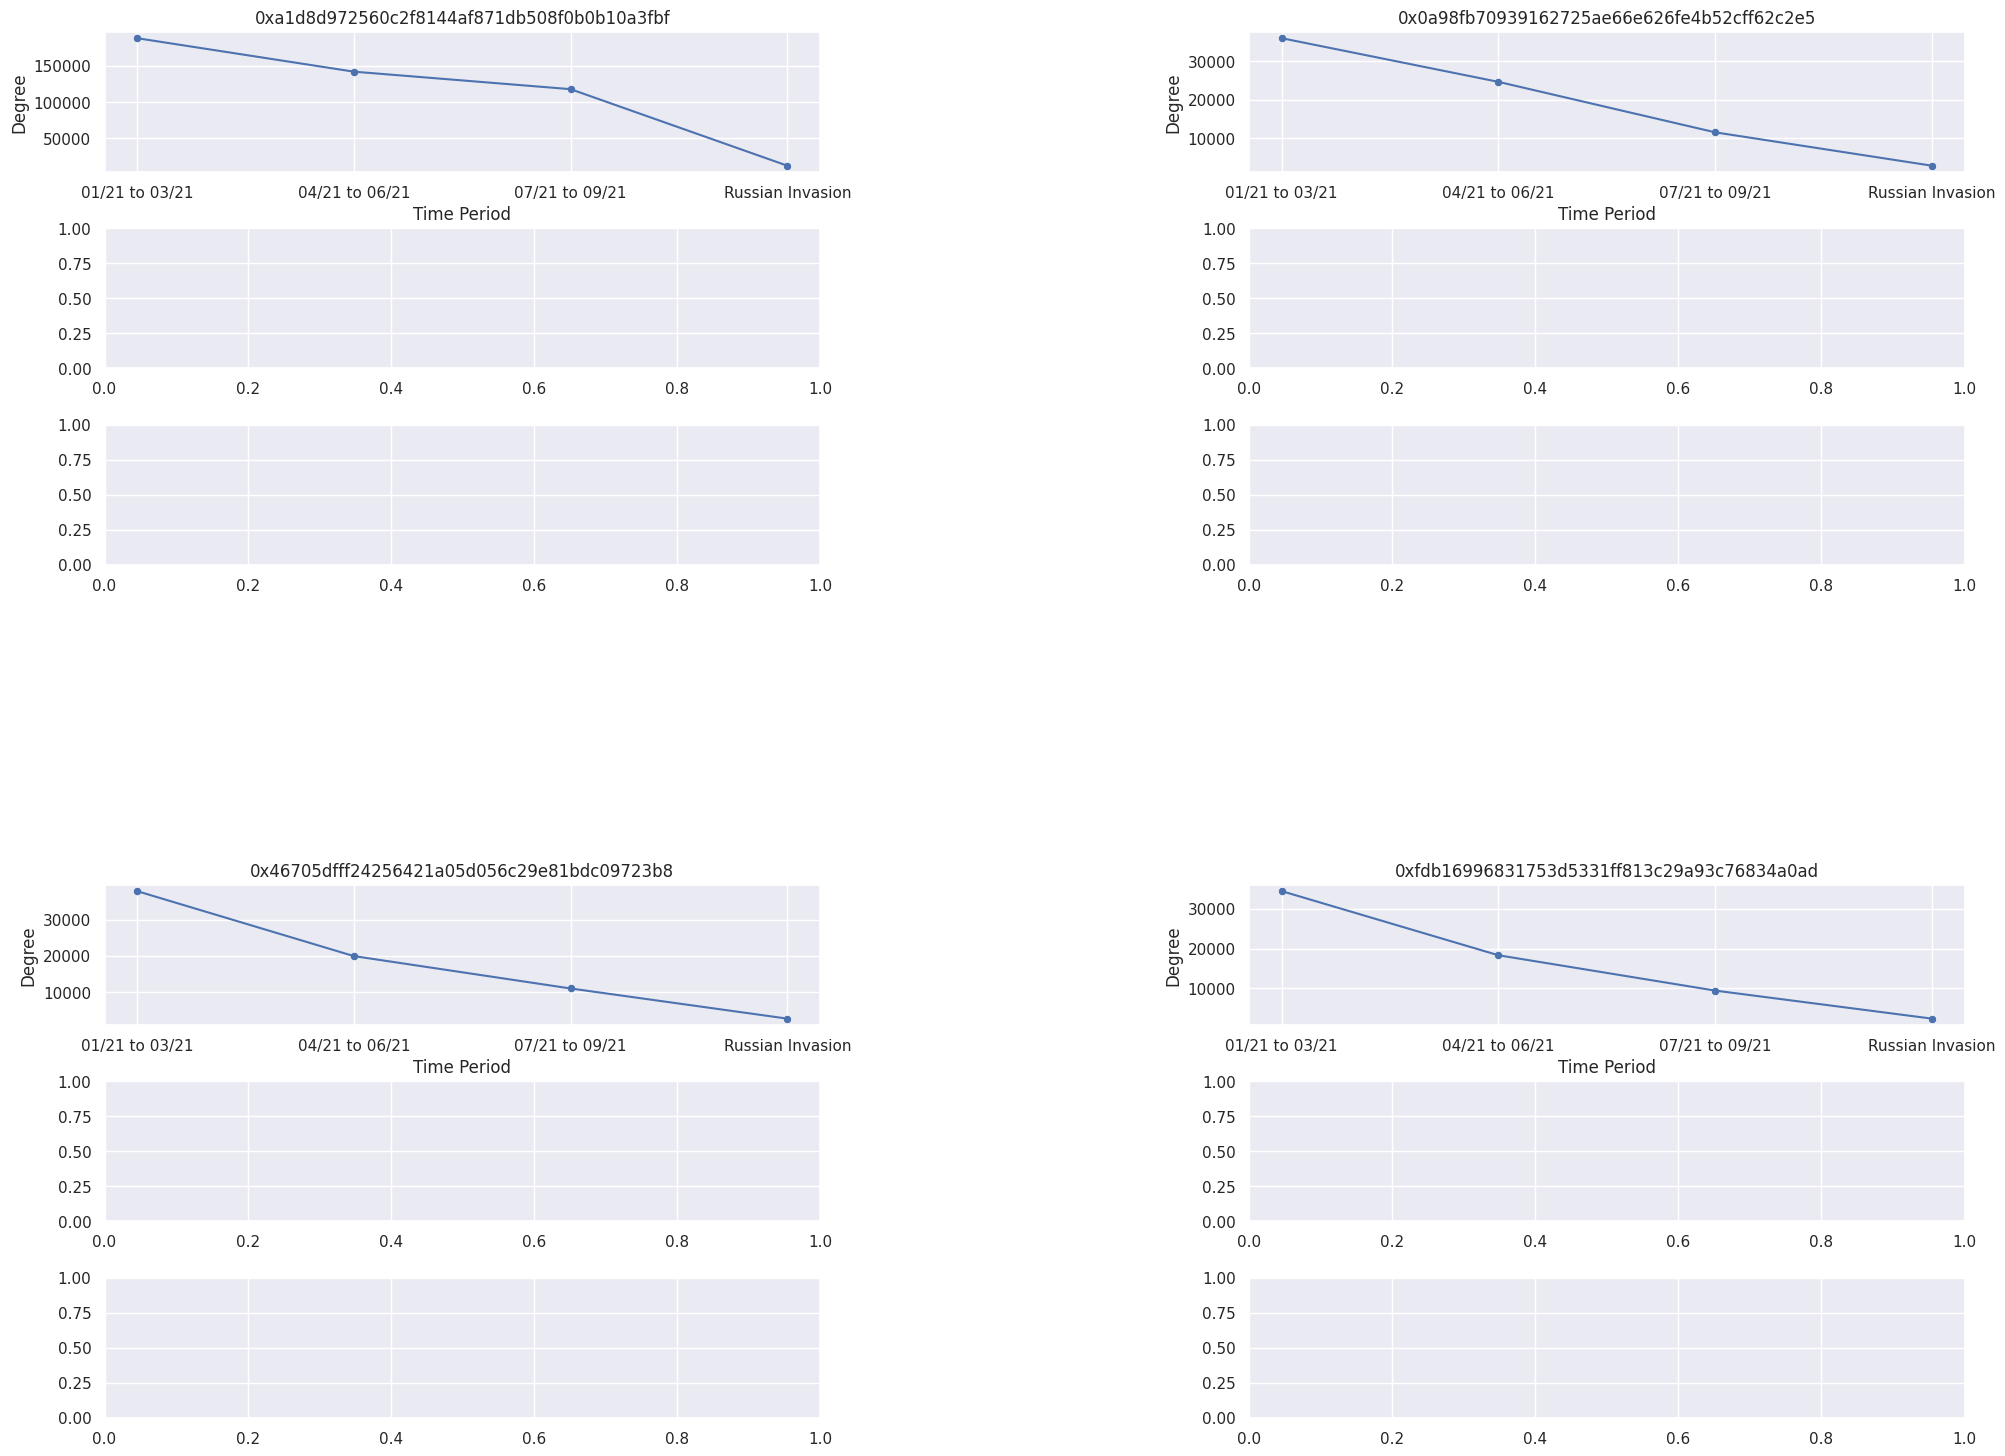

In [29]:
fig = plt.figure(figsize=(24, 18))
hash_list = [
    '0xa1d8d972560c2f8144af871db508f0b0b10a3fbf',
    '0x0a98fb70939162725ae66e626fe4b52cff62c2e5',
    '0x46705dfff24256421a05d056c29e81bdc09723b8',
    '0xfdb16996831753d5331ff813c29a93c76834a0ad'
]
plot_ascending_accounts(des_df, hash_list, fig, lookup_in, lookup_out)

## Novidades

<Axes: xlabel='degree'>

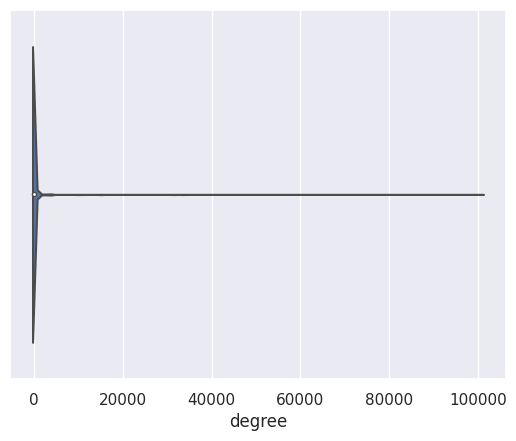

In [26]:
sns.violinplot(data = asc_df, x = 'degree')

<Axes: xlabel='degree'>

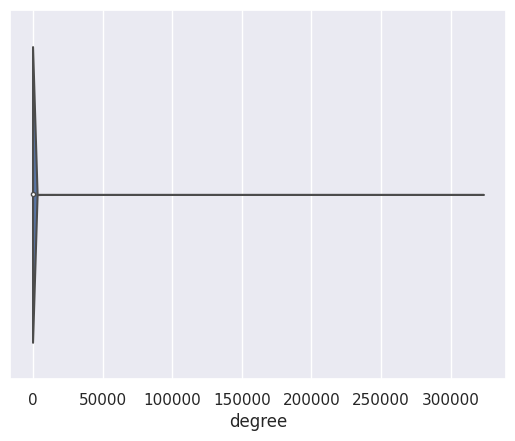

In [37]:
sns.violinplot(data = dec_df, x = 'degree')

<Axes: xlabel='degree'>

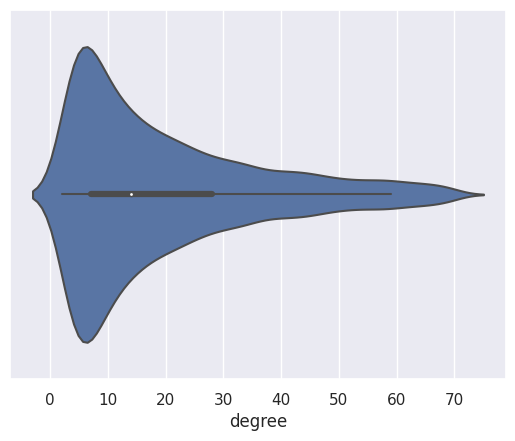

In [44]:
asc_iqr = asc_df['degree'].quantile(.75) - asc_df['degree'].quantile(.25)
asc_median = asc_df['degree'].quantile(.5)
sns.violinplot(data = asc_df[asc_df['degree'] < asc_median + 1.5 * asc_iqr], x = 'degree')


<Axes: xlabel='degree'>

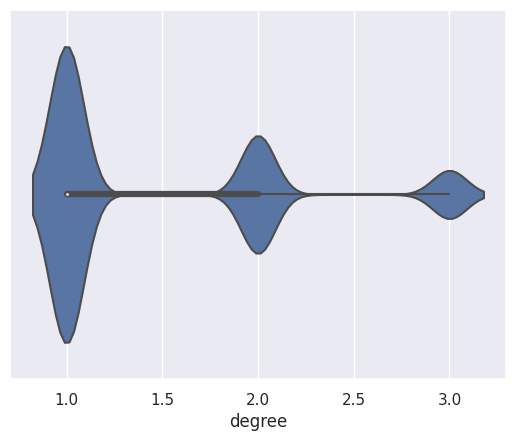

In [46]:
dec_iqr = dec_df['degree'].quantile(.75) - dec_df['degree'].quantile(.25)
dec_median = dec_df['degree'].quantile(.5)
sns.violinplot(data = dec_df[dec_df['degree'] < dec_median + 1.5 * dec_iqr], x = 'degree')

<BarContainer object of 2 artists>

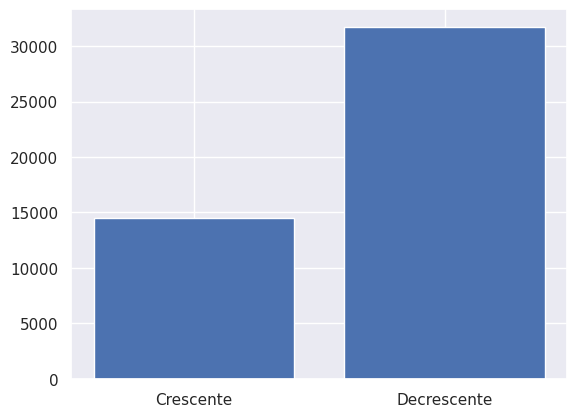

In [41]:
plt.bar(x = ['Crescente', 'Decrescente'], height = [len(asc_df), len(dec_df)])

<BarContainer object of 2 artists>

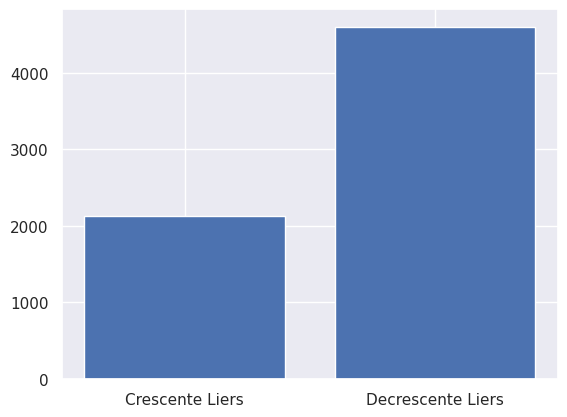

In [47]:
count_asc_liers = len(asc_df[asc_df['degree'] > asc_median + 1.5 * asc_iqr])
count_dec_liers = len(dec_df[dec_df['degree'] > dec_median + 1.5 * dec_iqr])
plt.bar(x = ['Crescente Liers', 'Decrescente Liers'], height = [count_asc_liers, count_dec_liers])

<BarContainer object of 2 artists>

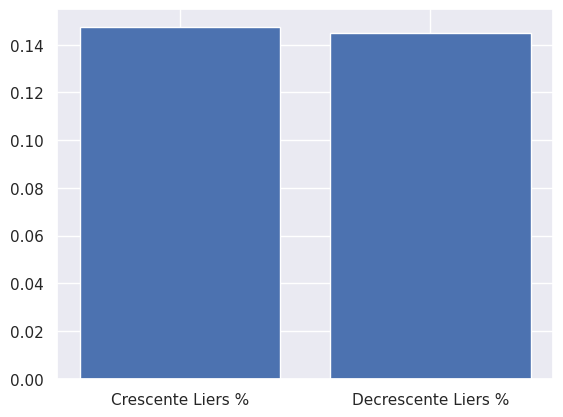

In [48]:
percent_asc_liers = len(asc_df[asc_df['degree'] > asc_median + 1.5 * asc_iqr])/len(asc_df)
percent_dec_liers = len(dec_df[dec_df['degree'] > dec_median + 1.5 * dec_iqr])/len(dec_df)
plt.bar(x = ['Crescente Liers %', 'Decrescente Liers %'], height = [percent_asc_liers, percent_dec_liers])